In [5]:
import yfinance as yf
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
from datetime import datetime

In [7]:
def fetch_options_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    options_dates = ticker.options
    # We'll use the nearest expiry date for our analysis
    options_data = ticker.option_chain(options_dates[0])
    return options_data.calls, options_data.puts



In [8]:
# Example usage:
jpm_calls, jpm_puts = fetch_options_data('JPM')
print(jpm_calls, jpm_puts)

        contractSymbol             lastTradeDate  strike  lastPrice  bid  \
0   JPM250103C00125000 2025-01-02 19:20:21+00:00   125.0     115.20  0.0   
1   JPM250103C00185000 2024-12-27 17:08:35+00:00   185.0      55.25  0.0   
2   JPM250103C00190000 2024-12-30 19:31:30+00:00   190.0      50.74  0.0   
3   JPM250103C00195000 2024-12-17 15:01:40+00:00   195.0      43.48  0.0   
4   JPM250103C00200000 2024-12-27 17:04:52+00:00   200.0      40.54  0.0   
5   JPM250103C00202500 2024-12-31 14:45:21+00:00   202.5      38.25  0.0   
6   JPM250103C00205000 2024-12-31 14:45:21+00:00   205.0      35.87  0.0   
7   JPM250103C00210000 2025-01-02 16:02:45+00:00   210.0      31.80  0.0   
8   JPM250103C00215000 2024-12-31 17:04:41+00:00   215.0      24.73  0.0   
9   JPM250103C00217500 2024-12-27 16:50:51+00:00   217.5      23.55  0.0   
10  JPM250103C00220000 2025-01-02 20:52:46+00:00   220.0      20.50  0.0   
11  JPM250103C00222500 2025-01-02 19:25:34+00:00   222.5      17.90  0.0   
12  JPM25010

In [9]:
jpm_stock_data = yf.download('JPM', start='2020-01-01', end=datetime.now().strftime('%Y-%m-%d'))


[*********************100%***********************]  1 of 1 completed


In [10]:
jpm_stock_data.head

<bound method NDFrame.head of Price            Close        High         Low        Open    Volume
Ticker             JPM         JPM         JPM         JPM       JPM
Date                                                                
2020-01-02  122.104614  122.113277  120.520862  120.979542  10803700
2020-01-03  120.493271  121.268455  119.395824  119.761639  10386800
2020-01-06  120.397469  120.432316  118.890653  118.942911  10259000
2020-01-07  118.350624  120.075188  118.298367  119.570010  10531300
2020-01-08  119.273888  119.831323  118.106759  118.193851   9695300
...                ...         ...         ...         ...       ...
2024-12-26  243.139999  243.259995  240.789993  241.429993   4451800
2024-12-27  241.169998  243.389999  240.039993  242.720001   5730200
2024-12-30  239.320007  240.839996  237.110001  238.770004   5723800
2024-12-31  239.710007  241.440002  239.029999  240.050003   4871000
2025-01-02  240.000000  243.279999  239.449997  240.919998   9213400

[12

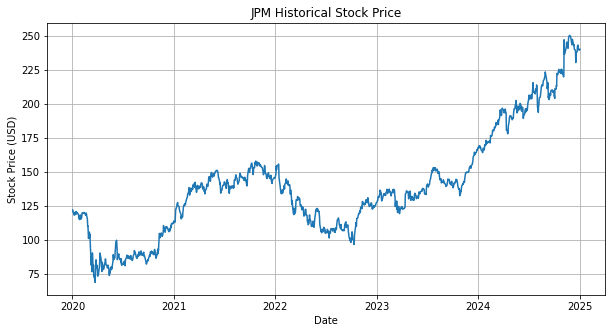

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(jpm_stock_data['Close'])
plt.title('JPM Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)

In [12]:
class BlackScholesModel:
    def __init__(self, S, K, T, r, sigma):
        self.S = S        # Underlying asset price
        self.K = K        # Option strike price
        self.T = T        # Time to expiration in years
        self.r = r        # Risk-free interest rate
        self.sigma = sigma  # Volatility of the underlying asset

    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def call_option_price(self):
        return (self.S * si.norm.cdf(self.d1(), 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def put_option_price(self):
        return (self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.d1(), 0.0, 1.0))


In [21]:
bsm = BlackScholesModel(S=100, K=100, T=1, r=0.05, sigma=0.2)
print(f"Call Option Price: {bsm.call_option_price()}")
print(f"Put Option Price: {bsm.put_option_price()}")

def calculate_historical_volatility(stock_data, window=252):
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    volatility = np.sqrt(window) * log_returns.std()
    return volatility

jpm_volatility = calculate_historical_volatility(jpm_stock_data)
print(f"JPM Historical Volatility: {jpm_volatility}")

Call Option Price: 10.450583572185565
Put Option Price: 5.573526022256971
JPM Historical Volatility: Ticker
JPM    0.324358
dtype: float64


In [14]:
class BlackScholesGreeks(BlackScholesModel):
    def delta_call(self):
        return si.norm.cdf(self.d1(), 0.0, 1.0)

    def delta_put(self):
        return -si.norm.cdf(-self.d1(), 0.0, 1.0)
    
    def gamma(self):
        return si.norm.pdf(self.d1(), 0.0, 1.0) / (self.S * self.sigma * np.sqrt(self.T))

    def theta_call(self):
        return (-self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * self.sigma / (2 * np.sqrt(self.T)) - self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0))
    
    def theta_put(self):
        return (-self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * self.sigma / (2 * np.sqrt(self.T)) + self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0))

    def vega(self):
        return self.S * si.norm.pdf(self.d1(), 0.0, 1.0) * np.sqrt(self.T)
    
    def rho_call(self):
        return self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0)
    
    def rho_put(self):
        return -self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(-self.d2(), 0.0, 1.0)


In [15]:
bsg = BlackScholesGreeks(S=100, K=100, T=1, r=0.05, sigma=0.2)
print(f"Call Delta: {bsg.delta_call()}")
print(f"Put Delta: {bsg.delta_put()}")

Call Delta: 0.6368306511756191
Put Delta: -0.3631693488243809


In [16]:
stock_prices = np.linspace(80, 120, 100)
deltas = [BlackScholesGreeks(S=price, K=100, T=1, r=0.05, sigma=0.2).delta_call() for price in stock_prices]

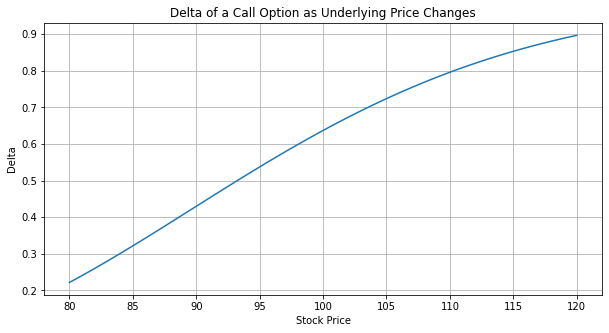

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(stock_prices, deltas)
plt.title('Delta of a Call Option as Underlying Price Changes')
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.grid(True)

In [18]:
def plot_option_sensitivity(bs_model, parameter, values, option_type='call'):
    prices = []
    for value in values:
        setattr(bs_model, parameter, value)
        if option_type == 'call':
            prices.append(bs_model.call_option_price())
        else:
            prices.append(bs_model.put_option_price())

    plt.figure(figsize=(10, 5))
    plt.plot(values, prices)
    plt.title(f'Option Price Sensitivity to {parameter.capitalize()}')
    plt.xlabel(parameter.capitalize())
    plt.ylabel('Option Price')
    plt.grid(True)

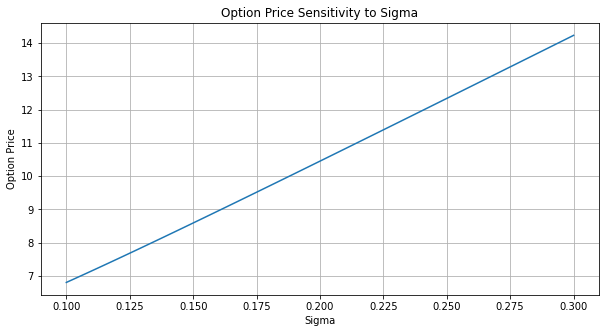

In [19]:
volatilities = np.linspace(0.1, 0.3, 100)
plot_option_sensitivity(bsm, 'sigma', volatilities, 'call')